# Exploratory Data Analysis Picks

#### 1. import libraries

In [5]:
# relevant libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from movingpandas import Trajectory
from shapely import Point, LineString
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar


#### 2. Import Data

In [6]:
# read in the data
traj = gpd.read_file('../scratch/traj.geojson')
picks = gpd.read_file('../scratch/picks.geojson')


In [7]:
trajectory = Trajectory(traj, traj_id='traj_id', t='t')

In [8]:
picks.head()

,id,verification,date_taken,lat,lon,total_litter,food_packaging,general_packaging,recycle_waste,waste_printed_information,cigarette_waste,other_waste,chewing_gum_waste,dense_urban_sidewalk,neighborhood_sidewalk,park,country_side,nature,url,geometry
0,452774,2,2023-08-19 10:12:31,52.648936,4.742886,1,NaN,NaN,NaN,None,NaN,1.0,NaN,NaN,1.0,NaN,NaN,None,https://openlittermap.com/tags?custom_tag=cert...,POINT (4.74289 52.64894)
1,452775,2,2023-08-19 10:14:10,52.648072,4.742731,1,NaN,NaN,NaN,None,NaN,1.0,NaN,NaN,1.0,NaN,NaN,None,https://openlittermap.com/tags?custom_tag=cert...,POINT (4.74273 52.64807)
2,452776,2,2023-08-19 10:14:19,52.647972,4.742767,1,NaN,NaN,NaN,None,NaN,1.0,NaN,NaN,1.0,NaN,NaN,None,https://openlittermap.com/tags?custom_tag=cert...,POINT (4.74277 52.64797)
3,452739,2,2023-08-19 10:16:04,52.647175,4.743067,1,NaN,NaN,NaN,None,1.0,NaN,NaN,NaN,1.0,NaN,NaN,None,https://openlittermap.com/tags?custom_tag=cert...,POINT (4.74307 52.64717)
4,452636,2,2023-08-19 10:18:19,52.645308,4.743550,2,NaN,1.0,NaN,None,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,https://openlittermap.com/tags?custom_tag=cert...,POINT (4.74355 52.64531)


In [9]:
def set_crs(gdf):
    gdf = gdf.set_crs(epsg=4326)
    gdf = gdf.to_crs(epsg=3857)
    return gdf

traj = set_crs(traj)
picks = set_crs(picks)

In [10]:
def set_start_time_picks(picks, traj):
    # Get the start time of the trajectory
    start_time = traj['t'].min()

    # sort the picks by time
    picks = picks.sort_values(by='date_taken')

    # Calculate the number of seconds from the start moment for each pick
    picks['minutes_from_start'] = (picks['date_taken'] - start_time).dt.total_seconds() /60

    return picks

picks = set_start_time_picks(picks, traj)

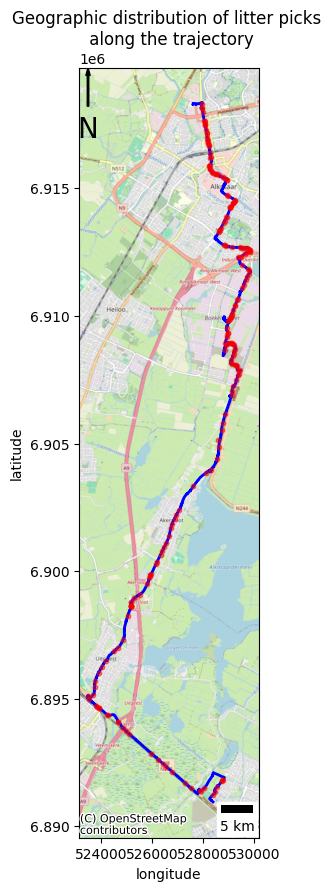

In [26]:
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches


# create a line from the trajectory
line = LineString(traj.geometry)
line_gdf = gpd.GeoDataFrame(geometry=[line])

# plot the line
fig, ax = plt.subplots(figsize=(10, 10))
line_gdf.plot(ax=ax, color='blue', linewidth=2)
picks.plot(ax=ax, color='red', markersize=10, label='Litter pick locations', zorder=2, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add a title and axis labels
ax.set_title('Geographic distribution of litter picks \n along the trajectory')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

# Add a scale bar
scalebar = ScaleBar(dx=4.0, location='lower right')
ax.add_artist(scalebar)

arrow = mpatches.Arrow(0.05, 0.95, 0, 0.05, width=0.04, transform=ax.transAxes, color='black')
ax.add_patch(arrow)
plt.text(0.05, 0.91, 'N', transform=ax.transAxes, ha='center', fontsize=20, color='black')


plt.show()


In [ ]:
print('Trajectory start time: ', traj['t'].min())
print('Trajectory end time: ', traj['t'].max())
print('Picks start time: ', picks['date_taken'].min())
print('Picks end time: ', picks['date_taken'].max())

Trajectory start time:  2023-08-19 10:08:43
Trajectory end time:  2023-08-19 16:22:21
Picks start time:  2023-08-19 12:12:31
Picks end time:  2023-08-19 18:19:32
Picks start time from start of trajectory:  123.8
Picks end time from start of trajectory:  490.81666666666666


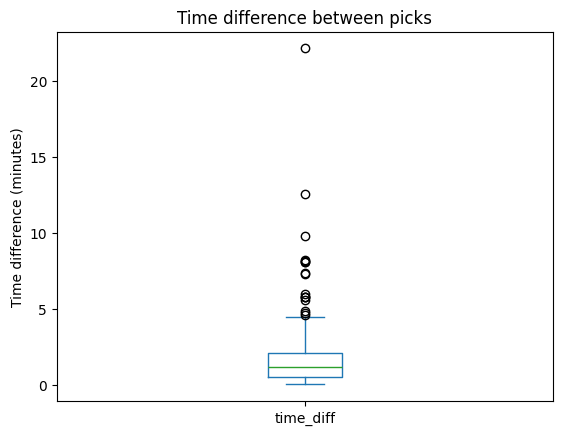

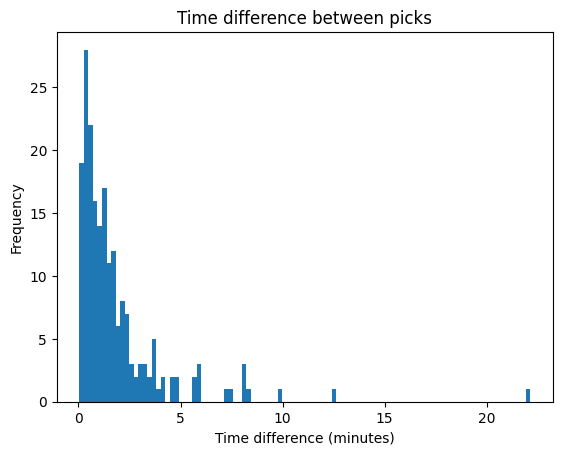

In [ ]:
# create a boxplot of the time differences between each pick
picks['time_diff'] = picks['minutes_from_start'].diff()
picks['time_diff'].plot(kind='box')
plt.title('Time difference between picks')
plt.ylabel('Time difference (minutes)')
plt.show()

# create a histogram of the time differences between each pick
picks['time_diff'].plot(kind='hist', bins=100)

plt.title('Time difference between picks')
plt.xlabel('Time difference (minutes)')
plt.ylabel('Frequency')
plt.show()


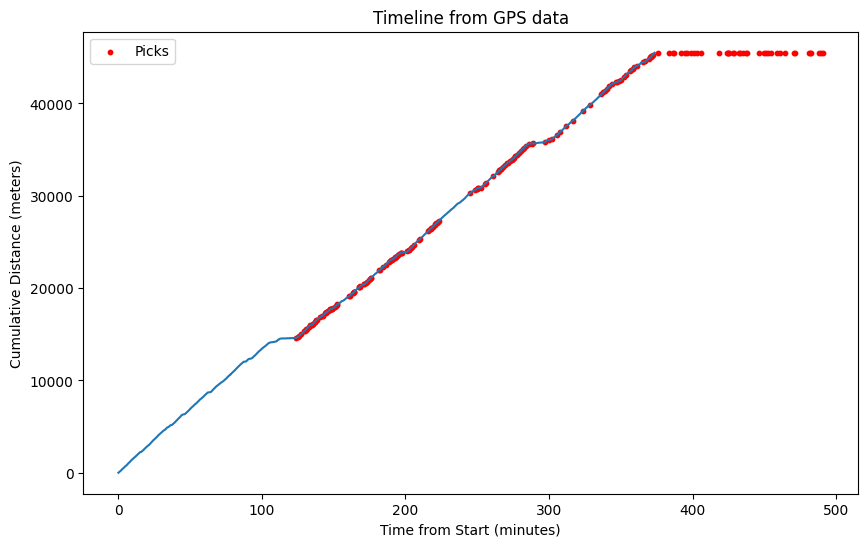

In [ ]:
# Calculate the time difference in minutes from the start
traj['minutes_from_start'] = (traj['t'] - traj['t'].iloc[0]).dt.total_seconds() / 60

# Calculate the distance to the previous point in meters
traj['distance_to_prev'] = traj.geometry.distance(traj.geometry.shift())
traj['distance_to_prev'] = traj['distance_to_prev'].fillna(0)

# Calculate the cumulative distance walked
traj['cumulative_distance'] = np.cumsum(traj['distance_to_prev'])

# Interpolate the 'cumulative_distance' at the 'time_from_start' for each pick
picks['cumulative_distance'] = np.interp(picks['minutes_from_start'], traj['minutes_from_start'], traj['cumulative_distance'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(traj['minutes_from_start'], traj['cumulative_distance'])
plt.scatter(picks['minutes_from_start'], picks['cumulative_distance'], color='red', label='Picks', s=10)
plt.xlabel('Time from Start (minutes)')
plt.ylabel('Cumulative Distance (meters)')
plt.title('Timeline from GPS data')
plt.legend()
plt.show()


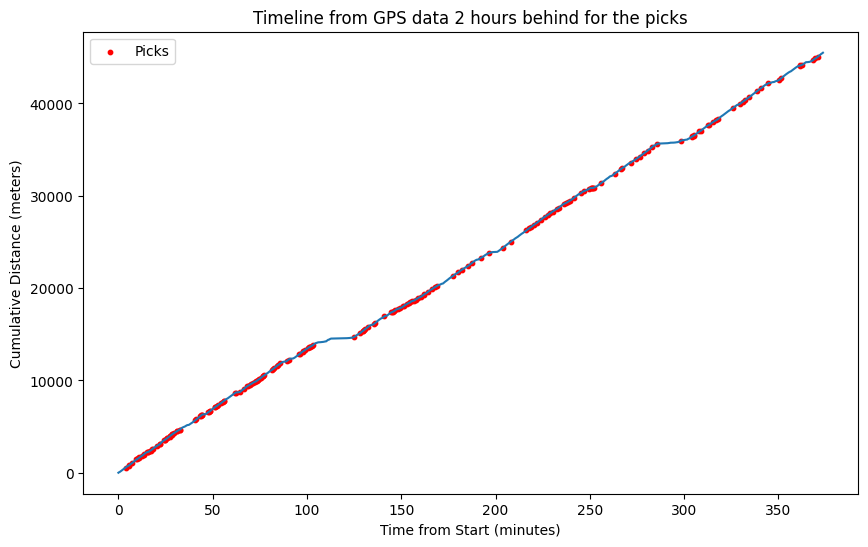

In [ ]:
def plot_trajectory_and_picks(traj, picks):
    # Subtract 2 hours from the 'date_taken' column
    picks["time_min_2_hours"] = picks["date_taken"] - pd.Timedelta(hours=2)

    # Get the start time of the trajectory
    start_time = traj['t'].min()

    # Calculate the number of minutes from the start moment for each pick
    picks['minutes_from_start'] = (picks['time_min_2_hours'] - start_time).dt.total_seconds() / 60

    # Interpolate the 'cumulative_distance' at the 'minutes_from_start' for each pick
    picks['cumulative_distance'] = np.interp(picks['minutes_from_start'], traj['minutes_from_start'], traj['cumulative_distance'])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(traj['minutes_from_start'], traj['cumulative_distance'])
    plt.scatter(picks['minutes_from_start'], picks['cumulative_distance'], color='red', label='Picks', s=10)
    plt.xlabel('Time from Start (minutes)')
    plt.ylabel('Cumulative Distance (meters)')
    plt.title('Timeline from GPS data 2 hours behind for the picks')
    plt.legend()
    plt.show()


plot_trajectory_and_picks(traj, picks)